# ADS 505 Team 1 Final Project: Credit Card Churn
Team Members: Shailja Somani, Jeremiah Fa’Atiliga, & Ebad Akhter\
Github Link: https://github.com/shailja-somani-0/ADS-505-Team-1/tree/main \
Kaggle Dataset Link: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?resource=download

## Set-Up

In [8]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import random

# Data Preprocessing Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Model building & evaluation imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import RFECV
from dmba import gainsChart, liftChart
%matplotlib inline

In [9]:
# Set all random seeds to 42
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [10]:
# Hide warnings to make code cleaner
import warnings
warnings.filterwarnings('ignore')

## Import Data & EDA

In [11]:
#Bank_df = pd.read_csv("Data/BankChurners.csv")
Bank_df = pd.read_csv("BankChurners.csv")
Bank_df = Bank_df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

In [4]:
Bank_df.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [87]:
missing_values_count = Bank_df.isnull().sum()
print(missing_values_count)

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


No missing values, so we don't have to worry about removing rows or imputing.

In [88]:
Bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

(array([1402.,    0., 3561.,    0., 1535.,    0., 1790.,    0.,  727.,
        1112.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

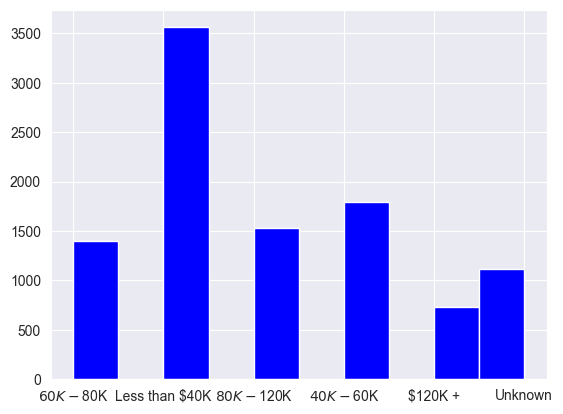

In [89]:
plt.hist(Bank_df["Income_Category"], bins = 10, color = 'blue')

In [90]:
# Select numerical columns
numerical_columns = Bank_df.select_dtypes(include=['number'])

# Display numerical columns
print(numerical_columns)

       CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
0      768805383            45                3              39   
1      818770008            49                5              44   
2      713982108            51                3              36   
3      769911858            40                4              34   
4      709106358            40                3              21   
...          ...           ...              ...             ...   
10122  772366833            50                2              40   
10123  710638233            41                2              25   
10124  716506083            44                1              36   
10125  717406983            30                2              36   
10126  714337233            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                 

In [91]:
# Get corr matrix for heatmap
correlation_matrix = numerical_columns.corr()

<Axes: >

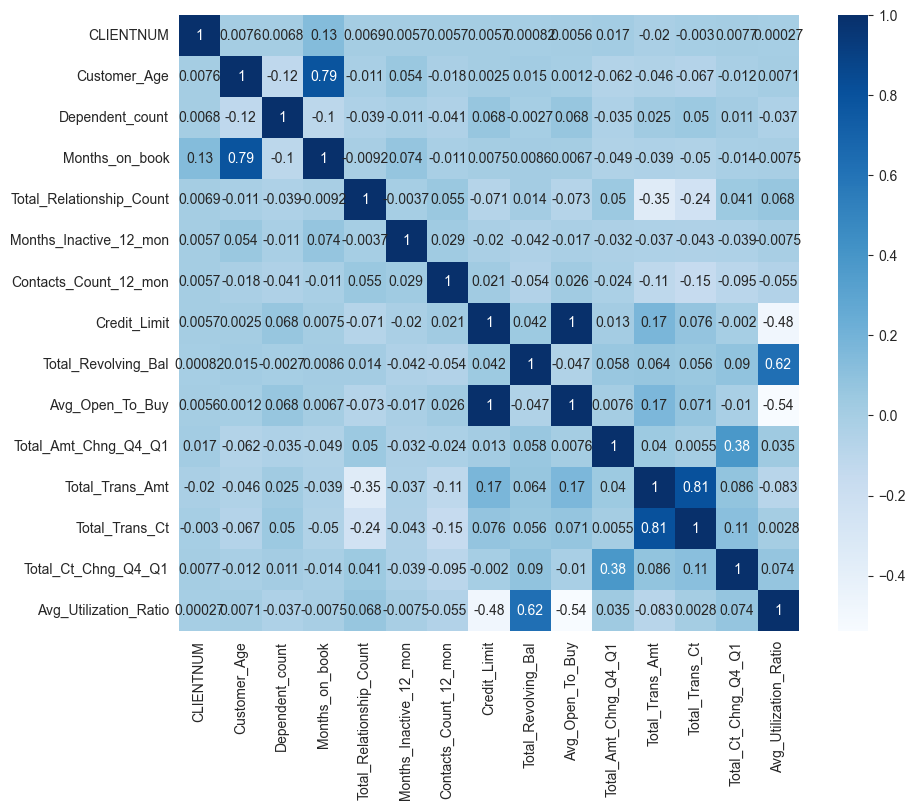

In [92]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues')

(array([110.,  29.,  56.,  70.,  91., 106., 127., 146., 184., 221., 260.,
        303., 333., 361., 379., 426., 473., 500., 486., 490., 479., 472.,
        947., 398., 376., 387., 307., 279., 262., 223., 157., 157., 127.,
         93.,  93.,  65.,  43., 101.,   2.,   4.,   2.,   0.,   1.,   0.,
          1.]),
 array([26.        , 27.04444444, 28.08888889, 29.13333333, 30.17777778,
        31.22222222, 32.26666667, 33.31111111, 34.35555556, 35.4       ,
        36.44444444, 37.48888889, 38.53333333, 39.57777778, 40.62222222,
        41.66666667, 42.71111111, 43.75555556, 44.8       , 45.84444444,
        46.88888889, 47.93333333, 48.97777778, 50.02222222, 51.06666667,
        52.11111111, 53.15555556, 54.2       , 55.24444444, 56.28888889,
        57.33333333, 58.37777778, 59.42222222, 60.46666667, 61.51111111,
        62.55555556, 63.6       , 64.64444444, 65.68888889, 66.73333333,
        67.77777778, 68.82222222, 69.86666667, 70.91111111, 71.95555556,
        73.        ]),
 <BarCon

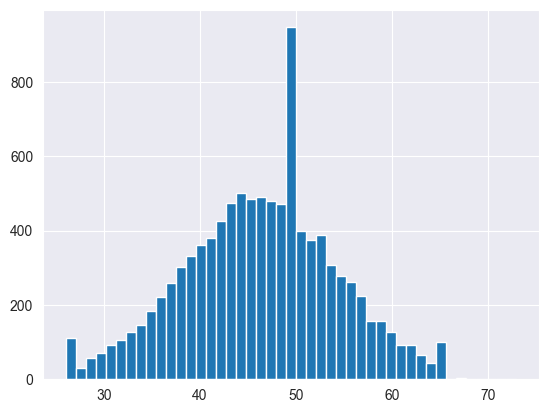

In [98]:
# Create histogram of customer age variable
plt.hist(Bank_df['Customer_Age'], bins = 45)

<AxesSubplot:xlabel='Customer_Age', ylabel='Density'>

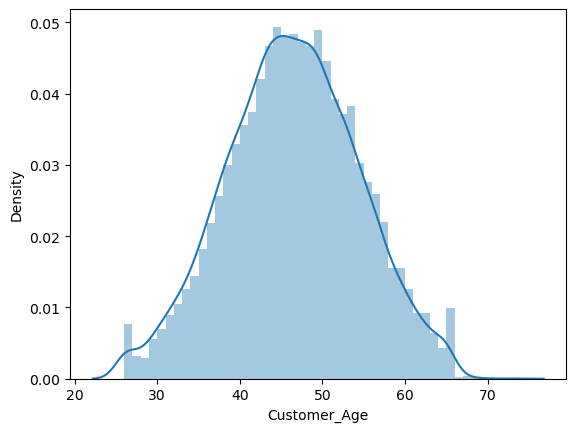

In [12]:
sns.distplot(Bank_df['Customer_Age'])

<AxesSubplot:xlabel='Education_Level', ylabel='count'>

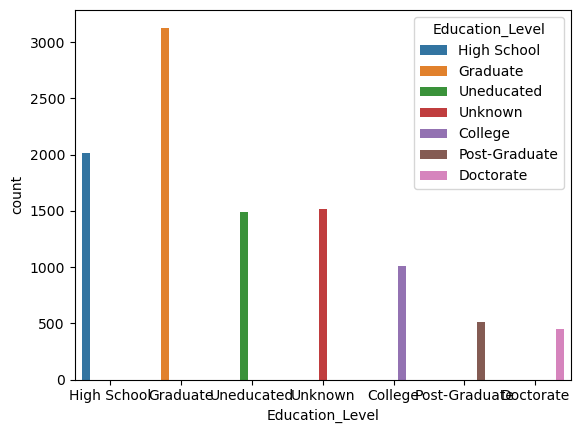

In [13]:
# Create barchart of education level
sns.countplot(data = Bank_df, x = 'Education_Level', hue = 'Education_Level')

## Data Pre-Processing for ML

In [11]:
# Drop the numerical client identifier as just a counter variable, which the model shouldn't perceive as actual predictor
Bank_df = Bank_df.drop(['CLIENTNUM'], axis=1)

### Convert Categorical Columns to Numerical

In [7]:
# Check which categorical columns only have binary values 
print(Bank_df["Gender"].unique())
print(Bank_df["Card_Category"].unique())

['M' 'F']
['Blue' 'Gold' 'Silver' 'Platinum']


In [14]:
# Convert categorical columns to dummies
Bank_df = pd.get_dummies(Bank_df, columns=['Gender', 'Card_Category', 'Education_Level',
                                                      'Marital_Status', 'Income_Category'])
#Bank_df.head()

In [13]:
Bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  10127 non-null  object 
 1   Customer_Age                    10127 non-null  int64  
 2   Dependent_count                 10127 non-null  int64  
 3   Months_on_book                  10127 non-null  int64  
 4   Total_Relationship_Count        10127 non-null  int64  
 5   Months_Inactive_12_mon          10127 non-null  int64  
 6   Contacts_Count_12_mon           10127 non-null  int64  
 7   Credit_Limit                    10127 non-null  float64
 8   Total_Revolving_Bal             10127 non-null  int64  
 9   Avg_Open_To_Buy                 10127 non-null  float64
 10  Total_Amt_Chng_Q4_Q1            10127 non-null  float64
 11  Total_Trans_Amt                 10127 non-null  int64  
 12  Total_Trans_Ct                  

In [15]:
# Drop one of the 2 cols for Gender bc it's binary to decrease multicollinearity issues
Bank_df = Bank_df.drop(['Gender_F'], axis=1)

### Stratified Train-Test Split & Scale Dataset

In [21]:
# Split the data into a stratified 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(Bank_df.drop(['Attrition_Flag'], axis=1), Bank_df['Attrition_Flag'], test_size=0.3, random_state = 42, stratify=Bank_df['Attrition_Flag'])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7088, 36)
(3039, 36)
(7088,)
(3039,)


In [22]:
# scale the features using standard scaler
scaler = StandardScaler()

# fit the scaler with training data only
X_train_scaled = scaler.fit_transform(X_train)

# transform the test data
X_test_scaled = scaler.transform(X_test)

### Balance Training Dataset (SMOTE)
We balance our training dataset to avoid issues in model training and certain model metrics caused by having an unbalanced dataset, such as the model primarily learning from and focusing on/predicting the majority class. We do not touch our test dataset.

Before: Counter({'Existing Customer': 5949, 'Attrited Customer': 1139})


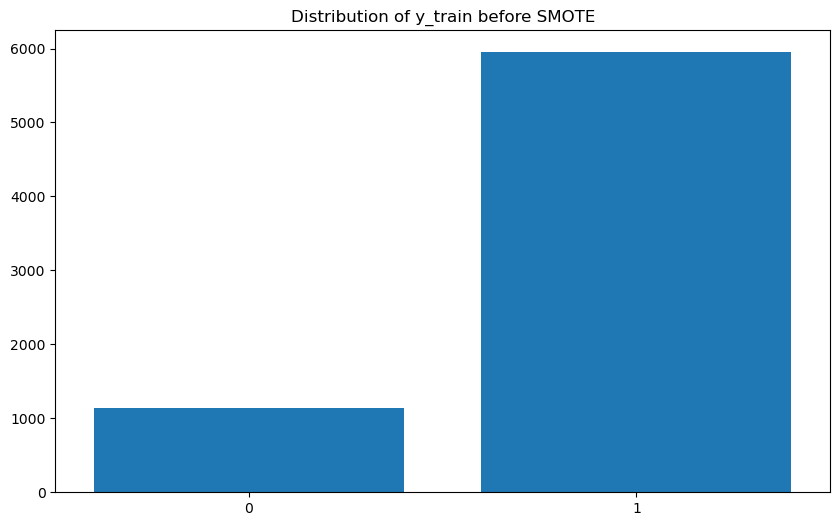

In [25]:
# Check distribution of target variable before using SMOTE
counter = Counter(y_train)
print("Before:", counter)
plt.figure(figsize=(10, 6))
plt.bar(counter.keys(), counter.values(), tick_label=[0, 1])
plt.title('Distribution of y_train before SMOTE')
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1])
plt.show()

In [26]:
# Implement SMOTE
smote = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

After: Counter({'Attrited Customer': 5949, 'Existing Customer': 5949})


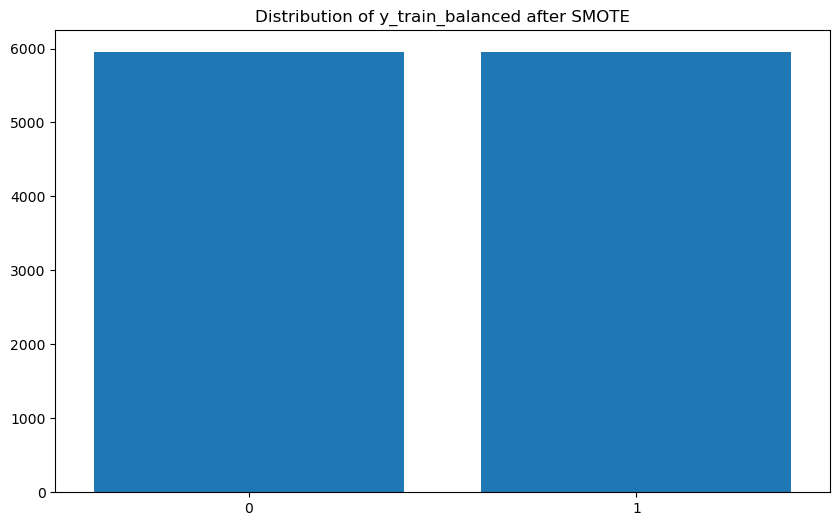

In [27]:
# Check distribution of target variable after SMOTE
counter = Counter(y_train_balanced)
print("After:", counter)
plt.figure(figsize=(10, 6))
plt.bar(counter.keys(), counter.values(), tick_label=[0, 1])
plt.title('Distribution of y_train_balanced after SMOTE')
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1])
plt.show()

## Model Building

### Testing Various Models & Hyperparams
We evaluate hyperparameters (via 5-fold cross validation) simulatenously while evaluating which model is best because we don't want to count a model out just becuase it was using suboptimal default hyperparameters. For evaluation, 5-fold cross validation is used on the balanced training dataset and the model with the optimal AUC is selected. We are using AUC for model evaluation because it incorporates both sensitivity and specificity rather than just one metric. 

In [45]:
# Loop through various models & hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(random_state=42), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
    }),
    ('Decision Tree', DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 5, 10, 15, 20],
    }),
    ('Random Forest', RandomForestClassifier(random_state=42), {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 15, 20],
    }),
    ('KNN', KNeighborsClassifier(), {  # KNN does not have a random_state parameter
        'n_neighbors': [3, 5, 7, 9, 11],
    }),
    ('AdaBoost', AdaBoostClassifier(random_state=42), {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 1]
    }),
    ('SVM', SVC(probability=True, random_state=42), {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale']
    }),
]

In [46]:
# Perform Grid Search CV (5-fold) for above models again using balanced training dataset
# Store the best models and their scores
best_models = {}
best_scores = {}
best_params = {}

for name, model, params in models:
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_balanced, y_train_balanced)
    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_
    best_params[name] = grid.best_params_

In [47]:
# Print the best scores and the best parameters for each model on the balanced dataset
for name in best_models:
    print(f"{name}: Best Score = {best_scores[name]}")
    print(f"Best Parameters = {best_params[name]}\n")

Logistic Regression: Best Score = 0.94250530434308
Best Parameters = {'C': 1, 'penalty': 'l2'}

Decision Tree: Best Score = 0.9646189188384996
Best Parameters = {'max_depth': 5}

Random Forest: Best Score = 0.9971641271954287
Best Parameters = {'max_depth': 20, 'n_estimators': 200}

KNN: Best Score = 0.958539420537423
Best Parameters = {'n_neighbors': 7}

AdaBoost: Best Score = 0.9938905664279268
Best Parameters = {'learning_rate': 1, 'n_estimators': 200}

SVM: Best Score = 0.9904027434354734
Best Parameters = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}



### Get AUC of Optimal Model (Random Forest) on Test Set
The Random Forest model performed the best with the hyperparameters listed above, so we will use that going forward. 

In [48]:
# Random Forest
rf = RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
rf_pred = rf.predict_proba(X_test_scaled)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred)
print(f'Random Forest AUC: {rf_auc}')

Random Forest AUC: 0.9824992288462898


### Try Recursive Feature Elimination (RFE)
Trying out RFE to see if we can remove extraneous features to keep the model performance high while decreasing model complexity & potential multicollinearity issues.

In [51]:
rf = RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='roc_auc')
rfecv.fit(X_train_balanced, y_train_balanced)

# Print the optimal number & ranking of features
print(f"Optimal number of features : {rfecv.n_features_}")
print(rfecv.ranking_)

# Transform the training data to just RFE # of features
X_train_balanced_optimal = rfecv.transform(X_train_balanced)
X_test_scaled_optimal = rfecv.transform(X_test_scaled)

# Refit the model on the optimal feature data & predict
rf.fit(X_train_balanced_optimal, y_train_balanced)
rf_pred_optimal = rf.predict_proba(X_test_scaled_optimal)[:, 1]

# Compute AUC on test set
rf_auc_optimal = roc_auc_score(y_test, rf_pred_optimal)
print(f'Optimal Random Forest RFE AUC: {rf_auc_optimal}')

Optimal number of features : 33
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal Random Forest RFE AUC: 0.9817160258593545


In [54]:
# Print selected feature names
selected_features_mask = rfecv.get_support()
selected_feature_names = X_train.columns[selected_features_mask]
print("Selected Feature Names:")
print(selected_feature_names)

Selected Feature Names:
Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_M', 'Card_Category_Blue', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Income_Category_Unknown'],
      dtype='object')


In [57]:
# Print features removed by RFE
selected_features = set(selected_feature_names)
all_features = set(X_train.columns)
print(all_features - selected_features)

{'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver'}


We can use the RFE model because it's a very minimal drop in AUC, but will make the model slightly simpler/less time-consuming and decrease multicollinearity issues from the card category dummy variables.

## Model Results

### Model Metrics

In [58]:
# Classification Report
y_pred = rf.predict(X_test_scaled_optimal)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

Attrited Customer       0.86      0.83      0.84       488
Existing Customer       0.97      0.97      0.97      2551

         accuracy                           0.95      3039
        macro avg       0.91      0.90      0.91      3039
     weighted avg       0.95      0.95      0.95      3039



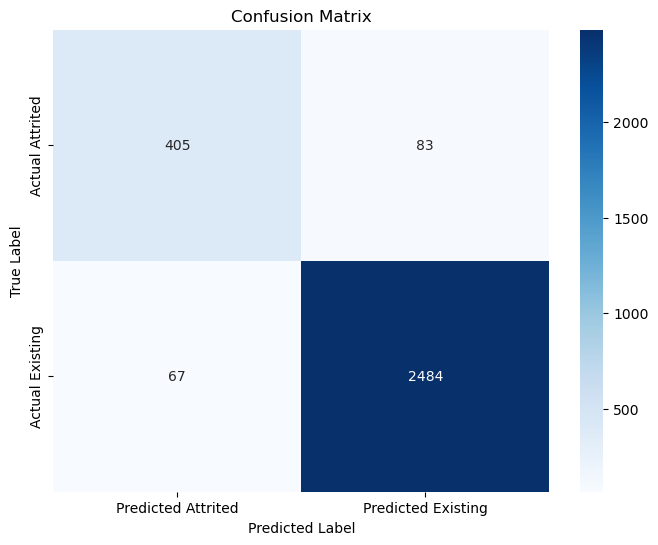

In [62]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Attrited', 'Predicted Existing'], 
            yticklabels=['Actual Attrited', 'Actual Existing'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Lift & Gains Charts

In [70]:
# Encode y for charts
encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test)

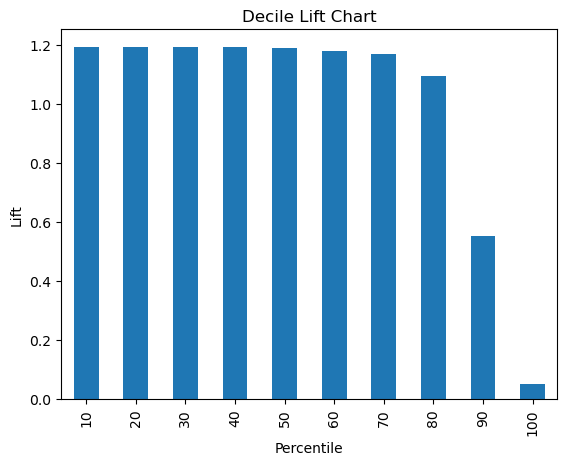

In [73]:
# Decile Lift Chart
y_pred_prob = rf.predict_proba(X_test_scaled_optimal)[:, 1]
df = pd.DataFrame({'actual': y_test_encoded, 'predicted': y_pred_prob})
df = df.sort_values(by='predicted', ascending=False)

liftChart(df['actual'], labelBars=False)
plt.ylabel('Lift')
plt.show()

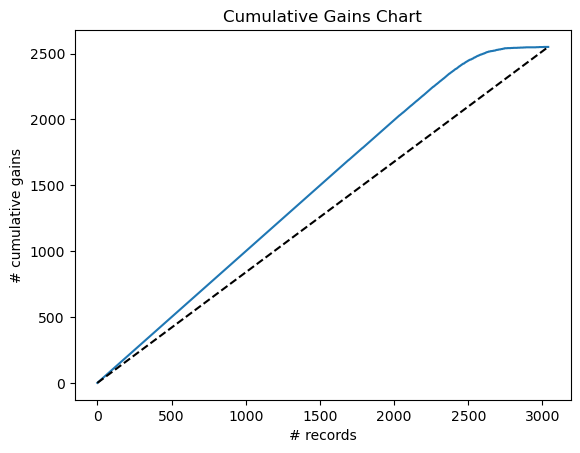

In [75]:
# Cumulative Gains Chart
gainsChart(df.actual)
plt.title('Cumulative Gains Chart')
plt.show()

### Feature Importance Graph for Final Model

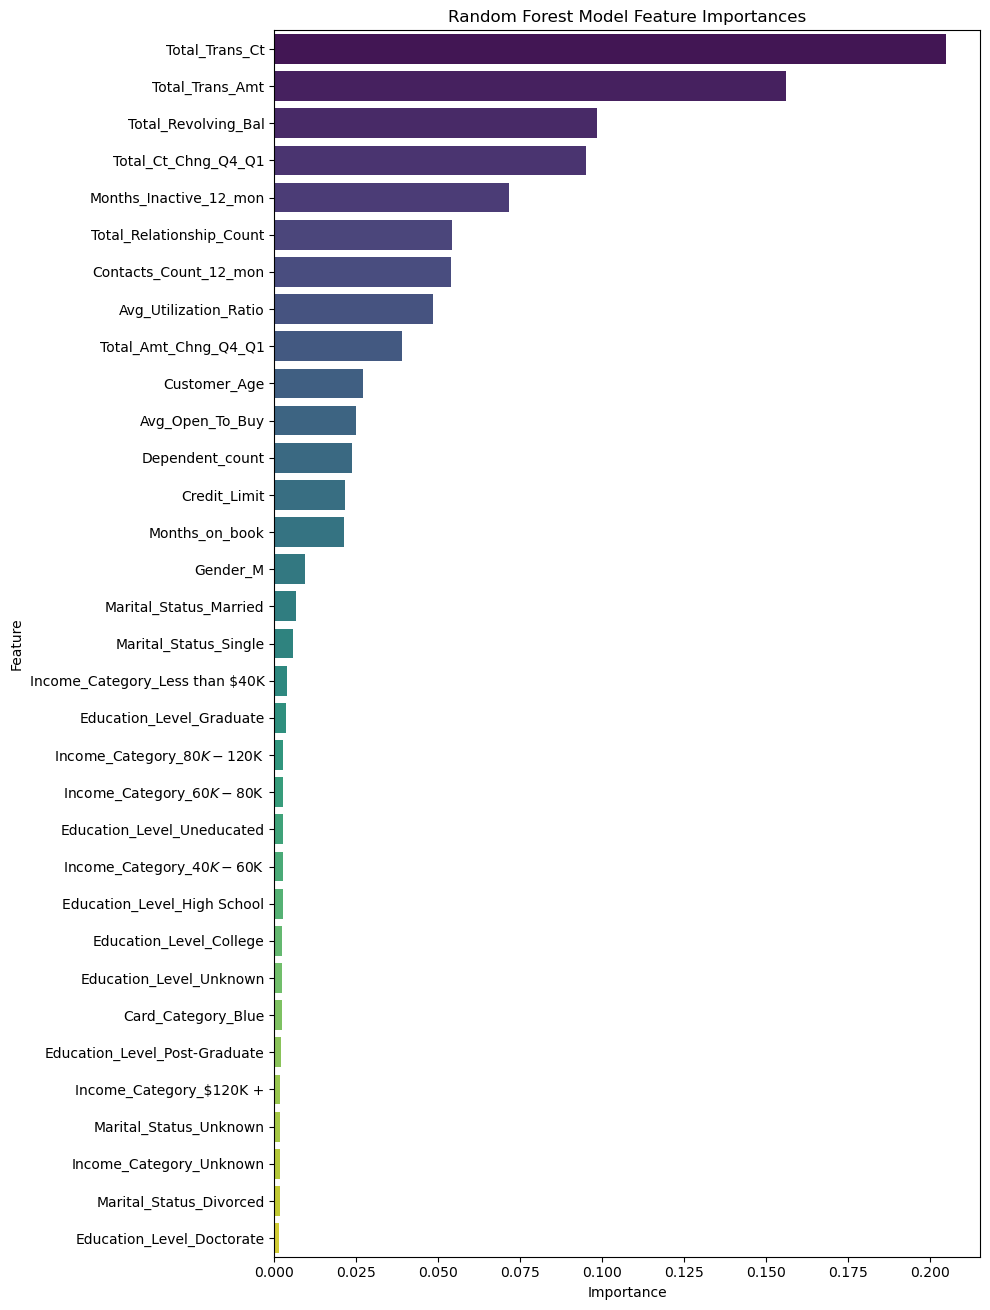

In [78]:
# Extract and map feature importances
feature_importances = rf.feature_importances_
feature_names = X_train.columns[selected_features_mask]
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features based on importance and convert to df
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
df_feature_importances = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Plotting
plt.figure(figsize=(10, len(sorted_features) * 0.4))
sns.barplot(x="Importance", y="Feature", data=df_feature_importances, palette='viridis')
plt.title('Random Forest Model Feature Importances')
plt.tight_layout()
plt.show()

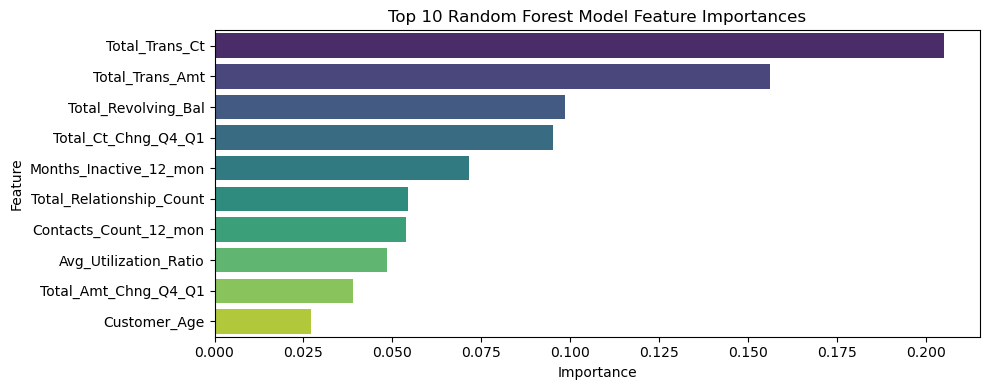

In [79]:
# Use only top 10 features for ease of reading graph
# Limit sorted_features to top 10 and convert to df
top_10_features = sorted_features[:10]  
df_feature_importances = pd.DataFrame(top_10_features, columns=['Feature', 'Importance'])

# Plotting
plt.figure(figsize=(10, len(top_10_features) * 0.4))
sns.barplot(x="Importance", y="Feature", data=df_feature_importances, palette='viridis')
plt.title('Top 10 Random Forest Model Feature Importances')
plt.tight_layout()
plt.show()

### Thresholding for Final Model
Based on different business needs, different classification thresholds may be used. The AUC remains constant throughout thresholds, but business needs may lend to a higher tolerance for FPs vs. FNs or vica-versa based on the business cost of a FP (wasted time/resources reaching out to consumers predicted to leave credit card service) vs. FN (loss of business from not reaching out to keep a client that ended up leaving the credit card service).

In [84]:
# Define the thresholds
thresholds = np.arange(0.25, 0.8, 0.05)
results = []

# Get TP, TN, FP, & FN at each threshold & append to results
for thresh in thresholds:
    rf_pred_class = (y_pred_prob > thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_encoded, rf_pred_class).ravel()
    results.append([thresh, tp, tn, fp, fn])

# Print results df
df_results = pd.DataFrame(results, columns=['Threshold', 'TP', 'TN', 'FP', 'FN'])
print(df_results)

    Threshold    TP   TN   FP   FN
0        0.25  2540  283  205   11
1        0.30  2532  308  180   19
2        0.35  2523  338  150   28
3        0.40  2516  365  123   35
4        0.45  2499  387  101   52
5        0.50  2484  403   85   67
6        0.55  2462  419   69   89
7        0.60  2435  441   47  116
8        0.65  2404  452   36  147
9        0.70  2348  464   24  203
10       0.75  2283  469   19  268


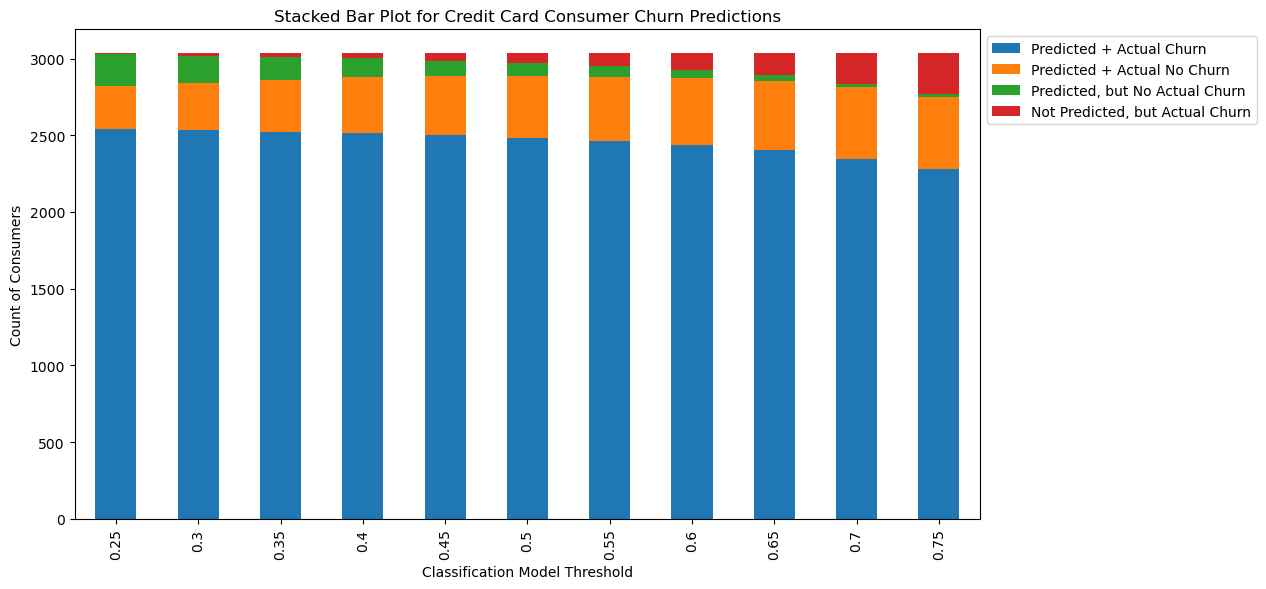

In [7]:
# Plotting
ax = df_results.plot(x='Threshold', y=['TP', 'TN', 'FP', 'FN'], kind='bar', stacked=True, figsize=(10, 6))

# Customize plot
plt.title('Stacked Bar Plot for Credit Card Consumer Churn Predictions')
plt.ylabel('Count of Consumers')
plt.xlabel('Classification Model Threshold')
plt.tight_layout()

# Set Legend
legend_labels = [
    'Predicted + Actual Churn',
    'Predicted + Actual No Churn',
    'Predicted, but No Actual Churn',
    'Not Predicted, but Actual Churn'
]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

Next steps are to:
* Work with Marketing & Consumer Outreach Teams to determine what action will be taken based on the predictions generated by this model to keep consumers predicted of churning. Possible actions include, but are not limited to: (a) waiving next annual fee, (b) calling to explain all credit card rewards/perks available to them, (c) rewarding extra bonus points for staying another year.
* Based on the cost of the above action, work with Marketing & Finance teams to set the classification threshold based on balancing the cost of a FP (could be \$0 if just a phone call explaining reasons to stay/perks of card or hundreds of dollars if waiving annual fee) and cost of a FN (loss of credit card interest, future annual fees, etc). 
* Train individual Account Managers to expect a monthly list generated by the model of consumers likely to churn & reach out to them using the actions decided above to convince them to remain with the credit card. 
* Deploy model in production. Report monthly metrics to business leaders. Adjust classification threshold as needed.